## Libraries

In [3]:
import csv
import pandas as pd
import seaborn as sns
from pymongo import MongoClient
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import avg

## Inserting Trimmed Data into MongoDB

In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Project"]
collection = db['ProjectCollection']
collection.drop()
# Define the batch size
batch_size = 1000

# === Trim and load data in batches ===
with open("project_file.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f) 
    batch = [] 

    # Goes through rows and adds them to batch
    for index, row in enumerate(reader, start=1):
        batch.append(row)
        
        # When batch is full, add to MongoDB
        if index % batch_size == 0:
            collection.insert_many(batch)  # Add batch to mongo
            batch.clear()  # Clear list before next batch
    
    # Load the remaining rows
    if batch:
        collection.insert_many(batch)
        print(f"✅ Inserted {len(batch)} rows of data (final batch)")

print("✅ Data import complete!")

✅ Inserted 350 rows of data (final batch)
✅ Data import complete!


## Starting Spark Session

In [44]:
spark = SparkSession.builder.appName("Bike Data Analysis").getOrCreate()

## Loading data from MongoDB via PyMongo

In [51]:
## Read documents, exclude '_id'
BikeData_docs = list(db["ProjectCollection"].find({}, {"_id": 0}))

# Convert to Spark DataFrames
BikeData = spark.createDataFrame(BikeData_docs)

total_rows = BikeData.count()
BikeData.show(10 )

print (f"Total number of rows: {total_rows}")

+--------------------+--------------------+----------------------+---------------+-------------------+-----------------+-------------------+-------------------+
|Covered distance (m)|Departure station id|Departure station name|Duration (sec.)|             Return|Return station id|Return station name|         ﻿Departure|
+--------------------+--------------------+----------------------+---------------+-------------------+-----------------+-------------------+-------------------+
|                1885|                 016|       Liisanpuistikko|            499|2021-05-01T00:08:15|              002|    Laivasillankatu|2021-04-30T23:59:54|
|                3359|                 020|     Kaisaniemenpuisto|            984|2021-05-01T00:16:16|              112| Rautatieläisenkatu|2021-04-30T23:59:52|
|                1633|                 004|             Viiskulma|            824|2021-05-01T00:13:40|              033|  Kauppakorkeakoulu|2021-04-30T23:59:52|
|                6459|            

In [53]:
print(BikeData.columns)

['Covered distance (m)', 'Departure station id', 'Departure station name', 'Duration (sec.)', 'Return', 'Return station id', 'Return station name', '\ufeffDeparture']


In [54]:
BikeData.printSchema()


root
 |-- Covered distance (m): string (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration (sec.): string (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



In [55]:
# Rename the columns
UpdatedBikeData = BikeData.withColumnRenamed("Covered distance (m)", "CoveredDistance_m") \
                 .withColumnRenamed("Duration (sec.)", "Duration_sec")


In [56]:
UpdatedBikeData.printSchema()

root
 |-- CoveredDistance_m: string (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration_sec: string (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



In [57]:
from pyspark.sql.functions import col

# Change datatype string → integer
UpdatedBikeData = UpdatedBikeData.withColumn("CoveredDistance_m", col("CoveredDistance_m").cast("int")) \
                 .withColumn("Duration_sec", col("Duration_sec").cast("int"))


In [58]:
UpdatedBikeData.printSchema()

root
 |-- CoveredDistance_m: integer (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration_sec: integer (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



## Counting the Average Values for Distance and Duration

In [59]:
data_selected = UpdatedBikeData.select(
    "CoveredDistance_m",
    "Departure station name",
    "Duration_sec"
)

# Calculating averages
df_avg_Dur_Dist = data_selected.groupBy(
    "Departure station name"
).agg(
    avg("CoveredDistance_m").alias("avg_distance_m"),
    avg("Duration_sec").alias("avg_duration_sec")
).orderBy("avg_distance_m", ascending=False)

# Show 10 longest distance departure stations
df_avg_Dur_Dist.show(10, truncate=False)


+----------------------+------------------+------------------+
|Departure station name|avg_distance_m    |avg_duration_sec  |
+----------------------+------------------+------------------+
|Lepolantie            |4358.806896551724 |1313.6301369863013|
|Mäkitorpantie         |3731.813953488372 |1135.4797687861271|
|Vesakkotie            |3697.2485875706216|1307.3022598870057|
|Keilalahti            |3682.304195804196 |1163.993006993007 |
|Hanasaari             |3618.634328358209 |1132.1322160148975|
|Aulangontie           |3611.904255319149 |1165.904255319149 |
|Näyttelijäntie        |3611.388174807198 |1223.6478149100258|
|Luoteisväylä          |3538.4404958677687|1226.4269199009084|
|Suurpellonaukio       |3524.651376146789 |1142.1146788990825|
|Reiherintie           |3503.9317406143346|1149.0546075085324|
+----------------------+------------------+------------------+
only showing top 10 rows



## Changing Average Duration from Seconds to Minutes and Rounding the Results

In [60]:
from pyspark.sql.functions import round, col
from pyspark.sql.types import IntegerType

#Changing "avg_duration_sec" -> "avg_duration_min", and rounding to 2 decimals
df_avg_Dur_Dist = df_avg_Dur_Dist.withColumn("avg_duration_min", round(col("avg_duration_sec") / 60, 2)) \
               .drop("avg_duration_sec")

#Rounding average distance to 2 decimals
df_avg_Dur_Dist = df_avg_Dur_Dist.withColumn("avg_distance_m", round(col("avg_distance_m"), 2))

In [61]:
df_avg_Dur_Dist.orderBy("avg_duration_min", ascending=False).show(10, truncate=False)

+----------------------+--------------+----------------+
|Departure station name|avg_distance_m|avg_duration_min|
+----------------------+--------------+----------------+
|Eerikinkatu           |1993.53       |107.19          |
|Vanha Viertotie       |2982.93       |67.86           |
|Kiskontie             |2625.46       |61.72           |
|Jännetie              |3237.72       |54.66           |
|Roihupelto            |2420.44       |52.31           |
|Tilkantori            |2596.95       |45.48           |
|Hauenkallio           |1816.14       |40.62           |
|Mäkelänkatu           |2392.53       |40.02           |
|Teljäntie             |2962.01       |36.41           |
|Merihaka              |2585.85       |36.22           |
+----------------------+--------------+----------------+
only showing top 10 rows



## Counting the visit number for departure stations

In [ ]:
from pyspark.sql import functions as F

# Counting most visited stations
most_visited_stations = BikeData.groupBy("Departure station id", "Departure station name") \
    .agg(F.count("*").alias("visit_count")) \
    .orderBy(F.col("visit_count").desc())

# Showing top 10
most_visited_stations.show(10, truncate=False)


+--------------------+-------------------------------------+-----------+
|Departure station id|Departure station name               |visit_count|
+--------------------+-------------------------------------+-----------+
|030                 |Itämerentori                         |10166      |
|113                 |Pasilan asema                        |7686       |
|126                 |Kalasatama (M)                       |7436       |
|041                 |Ympyrätalo                           |7086       |
|021                 |Töölönlahdenkatu                     |5674       |
|026                 |Kamppi (M)                           |5164       |
|137                 |Arabian kauppakeskus                 |4892       |
|541                 |Aalto-yliopisto (M), Korkeakouluaukio|4872       |
|071                 |Hietaniemenkatu                      |4858       |
|064                 |Tyynenmerenkatu                      |4832       |
+--------------------+-----------------------------

In [73]:
# Counting least visited stations
least_visited_stations = BikeData.groupBy("Departure station id", "Departure station name") \
    .agg(F.count("*").alias("visit_count")) \
    .orderBy(F.col("visit_count"))

# Showing top 10
least_visited_stations.show(10, truncate=False)

+--------------------+----------------------+-----------+
|Departure station id|Departure station name|visit_count|
+--------------------+----------------------+-----------+
|279                 |Puotinkylän kartano   |32         |
|902                 |Derby Business Park   |92         |
|741                 |Gransinmäki           |106        |
|769                 |Lumivaarantie         |126        |
|277                 |Marjaniemi            |128        |
|538                 |Hagalundinpuisto      |162        |
|755                 |Kutsuntatie           |186        |
|633                 |Avaruuskatu           |196        |
|747                 |Leppävaaran uimahalli |200        |
|537                 |Innopoli              |202        |
+--------------------+----------------------+-----------+
only showing top 10 rows



## Visualization 

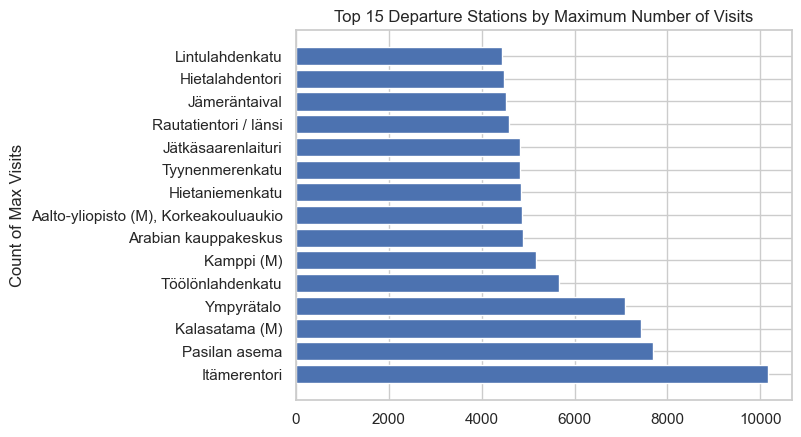

In [ ]:
# Bar Chart for 15 most visited departure stations 

top_df = most_visited_stations.limit(15).toPandas() 

plt.barh(top_df['Departure station name'], top_df['visit_count'])
plt.ylabel("Count of Max Visits")
plt.title("Top 15 Departure Stations by Maximum Number of Visits")
plt.show()


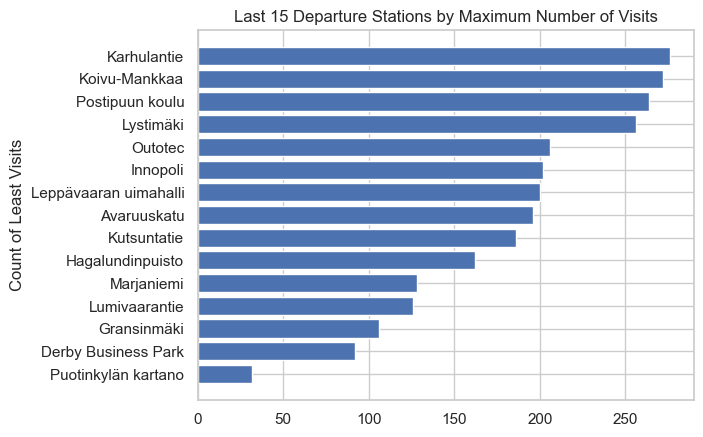

In [ ]:
# Bar Chart for 15 least visited departure stations 

least_df = least_visited_stations.limit(15).toPandas() 

plt.barh(least_df['Departure station name'], least_df['visit_count'])
plt.ylabel("Count of Least Visits")
plt.title("Last 15 Departure Stations by Maximum Number of Visits")
plt.show()

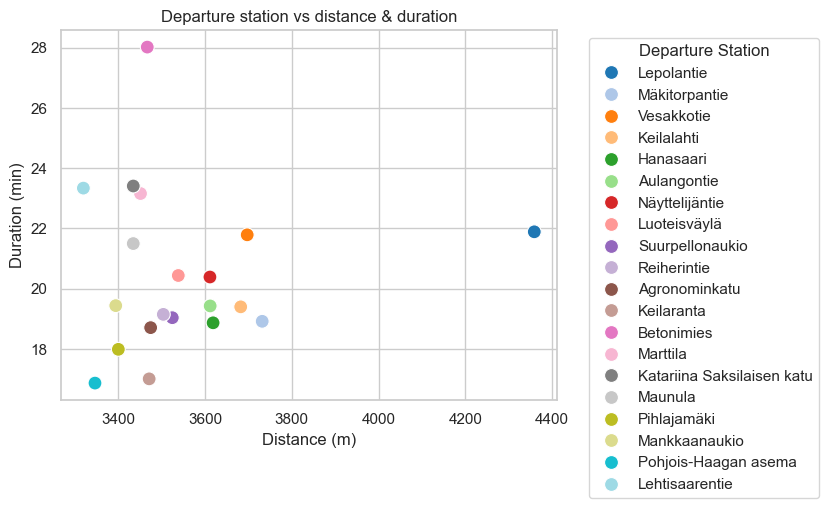

In [72]:
# Departure station vs Distance and Duration
top_departures = df_avg_Dur_Dist.limit(20).toPandas()
sns.scatterplot(top_departures, x='avg_distance_m', y='avg_duration_min',hue='Departure station name', palette='tab20', s=100)
plt.title("Departure station vs distance & duration")
plt.legend(title="Departure Station", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Distance (m)")
plt.ylabel("Duration (min)")
plt.show()

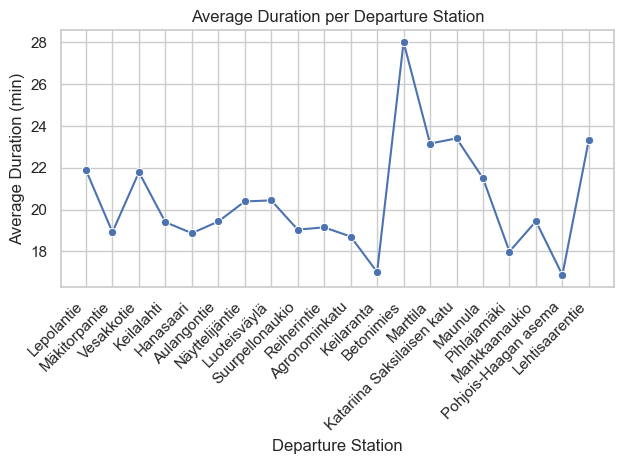

In [70]:
#Average Duration per Departure Station
sns.set(style="whitegrid")

sns.lineplot(
    data=top_departures,
    x='Departure station name',
    y='avg_duration_min',
    marker='o'
)
plt.xticks(rotation=45, ha='right')
plt.title("Average Duration per Departure Station")
plt.xlabel("Departure Station")
plt.ylabel("Average Duration (min)")
plt.tight_layout()
plt.show()
